# Import

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from mplsoccer import Pitch, VerticalPitch, Standardizer


# === Constants ===
PROJECT_ROOT_DIR = Path.cwd().parent.parent.parent
PROJECT_ROOT_DIR

def get_data(target:str = "position_level_0", match_played=2, minutes_played=90):
    """Merges all dimensions and applies filters"""
    # vars
    dimensions = ["defending","possession", "passing", "shooting", "goal_keeping"]
    df_standard_stats = pd.read_csv(f"{PROJECT_ROOT_DIR}/data/new_approach/standard_stats_all_final.csv",dtype={"player_id":"int32"}) # load_standard_stats(unique_index=True)

    # Merge all dimensions
    df = df_standard_stats[["player_id", "position_level_0", "position_level_1","position_level_2", "match_played", "minutes_played"]].copy()
    for dim in dimensions:
        # load
        df_dimension = pd.read_csv(f"{PROJECT_ROOT_DIR}/data/new_approach/{dim}_ex.csv",dtype={"player_id":"int32"})
        print(f"Dim {dim} shape{df_dimension.shape}")
        print("Columns:", df_dimension.columns.tolist())
        # merge and update base df
        df = pd.merge(
            left=df,
            right=df_dimension.loc[:, df_dimension.columns != "player"],
            left_on="player_id", 
            right_on="player_id",
            how="left"
        )
    print(f"Merge shape: {df.shape}")

    # filter rows
    print(f"Apply filters: match_played={match_played} , minutes_player={minutes_played}")
    df_filtered = df.loc[(df["match_played"]>=match_played) & (df["minutes_played"]>=minutes_played), : ].copy()#filter_df(df, match_played=match_played, minutes_played=minutes_played)

    # filter columns
    config_1_columns = ["player_id", "position_level_0", "position_level_1","position_level_2"]
    config_2_columns = ["player_id", "position_level_0", "position_level_1","position_level_2"]
    config_3_columns = ["player_id", "position_level_0", "position_level_1","position_level_2"]

    # load and merge selected features
    for dim in dimensions:
        path = f"{PROJECT_ROOT_DIR}/experiment_results/feature_selection_{target}/automated_{dim}.json"
        print(f"Load features from: {path}")
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        print("---")
        print(dim)
        config_1_columns.extend(data["conf_1"]["selected_columns"])
        #print(data["conf_1"]["selected_columns"])
        config_2_columns.extend(data["conf_2"]["selected_columns"])
        config_3_columns.extend(data["conf_3"]["selected_columns"])
    
    # Optionally remove duplicates if needed
    config_1_columns = list(set(config_1_columns))
    config_2_columns = list(set(config_2_columns))
    config_3_columns = list(set(config_3_columns))

    print("Config 1 columns:", len(config_1_columns))
    print("Config 2 columns:", len(config_2_columns))
    print("Config 3 columns:", len(config_3_columns))

    return (df_filtered.loc[:,config_1_columns].copy(), df_filtered.loc[:,config_2_columns].copy(), df_filtered.loc[:,config_3_columns].copy())



# Engineered Features
Get the count of total features

In [2]:
total_features = 0
dimensions = ["defending","possession", "passing", "shooting", "goal_keeping"]
for dim in dimensions:
    n_dim_features = 0
    # load
    df_dimension = pd.read_csv(f"{PROJECT_ROOT_DIR}/data/new_approach/{dim}_ex.csv",dtype={"player_id":"int32"})
    for c in df_dimension.columns:
        if c not in ["player_id", "player"]:
            total_features += 1
            n_dim_features += 1
    print(f"Dim {dim} features: {n_dim_features}")
print("Total features:", total_features)
            

Dim defending features: 119
Dim possession features: 254
Dim passing features: 338
Dim shooting features: 214
Dim goal_keeping features: 94
Total features: 1019


# Aggregated Player Vector Dataframe
shape

In [3]:
df = pd.DataFrame()

df = pd.read_csv(f"{PROJECT_ROOT_DIR}/data/new_approach/standard_stats_all_final.csv",dtype={"player_id":"int32"}) # load_standard_stats(unique_index=True)
df = df.set_index("player_id")


for dim in ["defending","possession", "passing", "shooting", "goal_keeping"]:
    # load
    df_dimension = pd.read_csv(f"{PROJECT_ROOT_DIR}/data/new_approach/{dim}_ex.csv",dtype={"player_id":"int32"})
    df_dimension = df_dimension.set_index("player_id")
    df = pd.merge(
            left=df,
            right=df_dimension.loc[:,df_dimension.columns != "player"],
            left_index=True,
            right_index=True,
            how="left"
        )
df.head(), df.shape

(                       player   country           team  match_played  \
 player_id                                                              
 2936       Christophe Kerbrat    France       Guingamp          30.0   
 2943              Lucas Deaux    France         Nantes          16.0   
 2944         Benjamin Corgnet    France  Saint-Étienne           9.0   
 2946        Frédéric Guilbert    France       Bordeaux          30.0   
 2947            Anthony Lopes  Portugal           Lyon          37.0   
 
            minutes_played  subbed_in  subbed_out  \
 player_id                                          
 2936               2613.0        1.0         1.0   
 2943               1181.0        3.0         3.0   
 2944                467.0        4.0         4.0   
 2946               2525.0        2.0         2.0   
 2947               3330.0        0.0         0.0   
 
                                      unique_positions_played  \
 player_id                                       

missing values (position level 0)

In [4]:
df.loc[df["player"]=="Jens Grahl", "position_level_0"]

player_id
37972    Goalkeeper
Name: position_level_0, dtype: object

count matches played

In [5]:
df["match_played"].value_counts().sort_index()

match_played
0.0     646
1.0      71
2.0     118
3.0      66
4.0      86
5.0      52
6.0      63
7.0      51
8.0      55
9.0      57
10.0     57
11.0     60
12.0     47
13.0     49
14.0     47
15.0     55
16.0     54
17.0     47
18.0     44
19.0     63
20.0     43
21.0     50
22.0     56
23.0     55
24.0     53
25.0     62
26.0     46
27.0     61
28.0     48
29.0     58
30.0     66
31.0     70
32.0     61
33.0     76
34.0     71
35.0     74
36.0     48
37.0     42
38.0     47
39.0     24
40.0     30
41.0     22
42.0     21
43.0     15
44.0     12
45.0     18
46.0     12
47.0      8
48.0      6
49.0      8
50.0      5
52.0      3
53.0      1
54.0      1
55.0      1
56.0      3
58.0      1
60.0      1
62.0      2
Name: count, dtype: int64

In [6]:
646 + 118 + 71

835

In [7]:
df["minutes_played"].value_counts().sort_index()

minutes_played
0.0       646
90.0       77
91.0        3
92.0       19
93.0       26
         ... 
3429.0      1
3431.0      1
3436.0      1
3453.0      1
3464.0      1
Name: count, Length: 1045, dtype: int64

In [8]:
646 + 77


723

In [9]:
df

,player,country,team,match_played,minutes_played,subbed_in,subbed_out,unique_positions_played,positions_played,full_match_equivalents,...,sweeper_in_defending_third_per_match,sweeper_in_middle_third_per_match,sweeper_collects_ball_per_match,sweeper_clears_ball_per_match,collecting_ball_total_per_match,collecting_ball_failed_per_match,collecting_ball_in_second_attempt_per_match,avg_distance_to_goal_per_match,avg_distance_to_goal_saved_shots_per_match,avg_distance_to_goal_goals_conceded_per_match
player_id,,,,,,,,,,,,,,,,,,,,,
2936,Christophe Kerbrat,France,Guingamp,30.0,2613.0,1.0,1.0,['Right Center Back'],"['Right Center Back', 'Right Center Back', 'Ri...",29.033333,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000
2943,Lucas Deaux,France,Nantes,16.0,1181.0,3.0,3.0,"['Right Defensive Midfield', 'Right Wing', 'Ce...","['Right Defensive Midfield', 'Left Defensive M...",13.122222,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000
2944,Benjamin Corgnet,France,Saint-Étienne,9.0,467.0,4.0,4.0,"['Center Attacking Midfield', 'Right Defensive...","['Center Attacking Midfield', 'Center Attackin...",5.188889,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000
2946,Frédéric Guilbert,France,Bordeaux,30.0,2525.0,2.0,2.0,"['Right Back', 'Right Center Back']","['Right Center Back', 'Right Back', 'Right Cen...",28.055556,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000
2947,Anthony Lopes,Portugal,Lyon,37.0,3330.0,0.0,0.0,['Goalkeeper'],"['Goalkeeper', 'Goalkeeper', 'Goalkeeper', 'Go...",37.000000,...,0.178,0.0,0.489,0.167,0.4,0.011,0.011,0.07,0.055,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403760,Victor Paillon,France,Troyes,0.0,0.0,0.0,0.0,[],[],0.000000,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000
404019,Douti Gbampok,France,Gazélec Ajaccio,0.0,0.0,0.0,0.0,[],[],0.000000,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000
404310,Gueïda Fofana,France,Lyon,0.0,0.0,0.0,0.0,[],[],0.000000,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.000


In [10]:
df.dtypes

player                                            object
country                                           object
team                                              object
match_played                                     float64
minutes_played                                   float64
                                                  ...   
collecting_ball_failed_per_match                 float64
collecting_ball_in_second_attempt_per_match      float64
avg_distance_to_goal_per_match                   float64
avg_distance_to_goal_saved_shots_per_match       float64
avg_distance_to_goal_goals_conceded_per_match    float64
Length: 1032, dtype: object

In [11]:
df_filtered = df[(df["match_played"]>=2) & (df["minutes_played"]>=90) ]
df_filtered["position_level_0"].value_counts()

position_level_0
Defender      826
Midfielder    795
Forward       547
Goalkeeper    184
Name: count, dtype: int64

# Passes Differences

__load data__

In [12]:
import sys
import os
import pandas as pd
import numpy as np
from ast import literal_eval
from mplsoccer import Pitch, VerticalPitch, Standardizer


# Run the notebook from inside the notebooks folder
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from scripts.dataloader import Dataloader

dataloader = Dataloader()
dataloader.load_data()

[2025-10-06 18:43:37] Loading raw event data from local file system


,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,...,goalkeeper_lost_out,goalkeeper_success_in_play,shot_follows_dribble,half_start_late_video_start,player_off_permanent,goalkeeper_lost_in_play,half_end_early_video_end,goalkeeper_penalty_saved_to_post,goalkeeper_saved_to_post,pass_backheel
0,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
1,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
2,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
3,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
4,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6391333,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
6391334,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
6391335,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None
6391336,NaN,<NA>,<NA>,None,<NA>,NaN,None,None,None,<NA>,...,<NA>,<NA>,<NA>,<NA>,None,None,None,None,None,None


convert x and y

In [13]:
def convert_to_list(input_data):
    if(isinstance(input_data, str)):
        try:
            return literal_eval(input_data)
        except (ValueError, SyntaxError):
            print(f"Error: The string {input_data} could not be converted to a list.")
            return None
    
    return input_data

df_event_data = dataloader.get_data()
df_event_data = df_event_data.loc[(df_event_data["type"]=="Carry") | ((df_event_data["type"]=="Pass")), ["player", "player_id","location","carry_end_location","pass_end_location", "type", "pass_shot_assist", "pass_goal_assist", "pass_angle","pass_outcome"]]
print("convert location")
df_event_data["location"] = df_event_data["location"].apply(convert_to_list)
df_event_data[["x", "y"]] = df_event_data["location"].apply(pd.Series)
print("convert carry location")
df_event_data["carry_end_location"] = df_event_data["carry_end_location"].apply(convert_to_list)
df_event_data[["x_end_carry", "y_end_carry"]] = df_event_data["carry_end_location"].apply(pd.Series)
print("convert pass location")
df_event_data["pass_end_location"] = df_event_data["pass_end_location"].apply(convert_to_list)
df_event_data[["x_end_pass", "y_end_pass"]] = df_event_data["pass_end_location"].apply(pd.Series)
df_event_data = df_event_data.set_index("player_id")
df_event_data.head()

convert location
convert carry location
convert pass location


,player,location,carry_end_location,pass_end_location,type,pass_shot_assist,pass_goal_assist,pass_angle,pass_outcome,x,y,x_end_carry,y_end_carry,x_end_pass,y_end_pass
player_id,,,,,,,,,,,,,,,
8387.0,Mark Uth,"[61.0, 40.1]",None,"[60.2, 37.9]",Pass,<NA>,<NA>,-1.919567,NaN,61.0,40.1,NaN,NaN,60.2,37.9
5460.0,Andrej Kramarić,"[59.4, 38.3]",None,"[53.9, 42.1]",Pass,<NA>,<NA>,2.536994,NaN,59.4,38.3,NaN,NaN,53.9,42.1
6039.0,Sebastian Rudy,"[52.3, 45.2]",None,"[34.3, 62.0]",Pass,<NA>,<NA>,2.390664,NaN,52.3,45.2,NaN,NaN,34.3,62.0
5537.0,Fabian Lukas Schär,"[34.3, 61.9]",None,"[37.5, 23.7]",Pass,<NA>,<NA>,-1.487222,NaN,34.3,61.9,NaN,NaN,37.5,23.7
12321.0,Tobias Strobl,"[38.5, 22.2]",None,"[36.7, 35.5]",Pass,<NA>,<NA>,1.705317,NaN,38.5,22.2,NaN,NaN,36.7,35.5


In [14]:
df_event_data.to_csv("../../../data/new_approach/eda_report_merged_event_data.csv")

In [15]:
df_event_data = pd.read_csv("../../../data/new_approach/eda_report_merged_event_data.csv")
df_event_data = df_event_data.set_index("player_id")
df_event_data.head()

,player,location,carry_end_location,pass_end_location,type,pass_shot_assist,pass_goal_assist,pass_angle,pass_outcome,x,y,x_end_carry,y_end_carry,x_end_pass,y_end_pass
player_id,,,,,,,,,,,,,,,
8387.0,Mark Uth,[61. 40.1],NaN,[60.2 37.9],Pass,NaN,NaN,-1.919567,NaN,61.0,40.1,NaN,NaN,60.2,37.9
5460.0,Andrej Kramarić,[59.4 38.3],NaN,[53.9 42.1],Pass,NaN,NaN,2.536994,NaN,59.4,38.3,NaN,NaN,53.9,42.1
6039.0,Sebastian Rudy,[52.3 45.2],NaN,[34.3 62. ],Pass,NaN,NaN,2.390664,NaN,52.3,45.2,NaN,NaN,34.3,62.0
5537.0,Fabian Lukas Schär,[34.3 61.9],NaN,[37.5 23.7],Pass,NaN,NaN,-1.487222,NaN,34.3,61.9,NaN,NaN,37.5,23.7
12321.0,Tobias Strobl,[38.5 22.2],NaN,[36.7 35.5],Pass,NaN,NaN,1.705317,NaN,38.5,22.2,NaN,NaN,36.7,35.5


## add context

In [16]:
import math 
PI = math.pi

def is_progressive_carry(start_x, start_y, end_x, end_y):
    """
    Check if a carry is progressive towards the goal area.
    
    A carry is progressive if the end position is closer to the goal area than the start position.
    
    Args:
        start_x (float): x-coordinate of the carry start position
        start_y (float): y-coordinate of the carry start position
        end_x (float): x-coordinate of the carry end position
        end_y (float): y-coordinate of the carry end position
        pitch_width (float): width of the pitch
        
    Returns:
        bool: True if the carry is progressive, False otherwise
    """
    goal_center_x = 120
    goal_center_y = 40
    
    # Calculate distances from start and end points to the goal center
    start_distance = ((start_x - goal_center_x) ** 2 + (start_y - goal_center_y) ** 2) ** 0.5
    end_distance = ((end_x - goal_center_x) ** 2 + (end_y - goal_center_y) ** 2) ** 0.5
    
    # A carry is progressive if the end point is closer to the goal center than the start point
    return end_distance < start_distance

def is_in_penalty_area(x, y):
    pitch_width = 120
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_vertical_pass(angle, max_tolerance=50):
    """
    Checks if the ball's movement is considered to be deep or vertical moving moving along side the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - max_tolerance (float): Maximum angle in degrees .

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle)


def is_horizontal_pass(angle, min_tolerance=75, max_tolerance=105):
    """
    Checks if the ball's movement is primarily horizontal based on the angle between the pass direction and the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - min_tolerance (float): Minimum angle in degrees (default is 75°).
    - max_tolerance (float): Maximum angle in degrees (default is 105°).

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle) >= min_tolerance

def is_progressive_pass(angle, tolerance=75):
    """
    Checks if the ball's movement angle (in radians) is a progressive pass and within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_backward_pass(angle, tolerance=105):
    """
    Checks if the ball's movement angle (in radians) is a defensive pass and within the allowed range of angle towards the own goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) > tolerance



df_with_flags = df_event_data.copy()

# merge with stats
df_standard_stats = pd.read_csv("../../../data/new_approach/standard_stats_all_final.csv")
df_standard_stats =  df_standard_stats.loc[(df_standard_stats["match_played"]>=2) & (df_standard_stats["minutes_played"]>=90), : ].copy()#filter_df(df, match_played=match_played, minutes_played=minutes_played)
df_standard_stats = df_standard_stats.set_index("player_id")
df_with_flags = pd.merge(
    left=df_with_flags, 
    right=df_standard_stats[["position_level_0", "position_level_1", "position_level_2"]], 
    left_index=True, 
    right_index=True, 
    how="left"
)

# location based
df_with_flags['is_attacking_third'] = df_event_data['x'] >= 80
df_with_flags['is_middle_third'] = (80 > df_event_data['x']) & (df_event_data['x'] > 40)
df_with_flags['is_defending_third'] = df_event_data['x'] <= 40
df_with_flags["is_left_side"] = df_event_data['y'] < 40
df_with_flags["is_right_side"] = df_event_data['y'] >= 40
df_with_flags["is_right_corner"] = (df_event_data['x'] >= 118) & (df_event_data['y'] >= 79)
df_with_flags["is_left_corner"] = (df_event_data['x'] >= 118) & (df_event_data['y'] < 2)
# df_with_flags

# progressive carry
# df_with_flags["carry_distance"] = np.sqrt((df_event_data["x_end_carry"] - df_event_data["x"])**2 + (df_event_data["y_end_carry"] - df_event_data["y"])**2)
# df_with_flags["start_to_goal_distance"] = np.sqrt( (df_event_data["x"] - 120)**2 + (df_event_data["y"] - 40)**2)
# df_with_flags["end_to_goal_distance"] = np.sqrt((df_event_data["x_end_carry"] - 120)**2 + (df_event_data["y_end_carry"] - 40)**2)
# df_with_flags['carry_ends_in_box'] = df_event_data[['x_end_carry','y_end_carry']].apply(lambda row: is_in_penalty_area(row['x_end_carry'], row['y_end_carry']), axis=1)
# df_with_flags["is_progressive_carry"] = df_with_flags["end_to_goal_distance"] < df_with_flags["start_to_goal_distance"]

# passes
# df_with_flags['pass_ends_in_box'] = df_event_data[['x_end_pass','y_end_pass']].apply(lambda row: is_in_penalty_area(row['x_end_pass'], row['y_end_pass']), axis=1)
df_with_flags['is_completed'] = df_event_data['pass_outcome'].isna()
df_with_flags['is_vertical'] = df_event_data['pass_angle'].apply(is_vertical_pass)
df_with_flags['is_horizontal'] = df_event_data['pass_angle'].apply(is_horizontal_pass)
df_with_flags['is_backward'] = df_event_data['pass_angle'].apply(is_backward_pass)
df_with_flags['is_progressive'] = df_event_data['pass_angle'].apply(is_progressive_pass)



df_with_flags['is_pass_shot_assist'] = df_event_data['pass_shot_assist'] == True
df_with_flags['is_pass_goal_assist'] = df_event_data['pass_goal_assist'] == True

df_with_flags.head()

,player,location,carry_end_location,pass_end_location,type,pass_shot_assist,pass_goal_assist,pass_angle,pass_outcome,x,...,is_right_side,is_right_corner,is_left_corner,is_completed,is_vertical,is_horizontal,is_backward,is_progressive,is_pass_shot_assist,is_pass_goal_assist
player_id,,,,,,,,,,,,,,,,,,,,,
8387.0,Mark Uth,[61. 40.1],NaN,[60.2 37.9],Pass,NaN,NaN,-1.919567,NaN,61.0,...,True,False,False,True,False,False,True,False,False,False
5460.0,Andrej Kramarić,[59.4 38.3],NaN,[53.9 42.1],Pass,NaN,NaN,2.536994,NaN,59.4,...,False,False,False,True,False,False,True,False,False,False
6039.0,Sebastian Rudy,[52.3 45.2],NaN,[34.3 62. ],Pass,NaN,NaN,2.390664,NaN,52.3,...,True,False,False,True,False,False,True,False,False,False
5537.0,Fabian Lukas Schär,[34.3 61.9],NaN,[37.5 23.7],Pass,NaN,NaN,-1.487222,NaN,34.3,...,True,False,False,True,False,True,False,False,False,False
12321.0,Tobias Strobl,[38.5 22.2],NaN,[36.7 35.5],Pass,NaN,NaN,1.705317,NaN,38.5,...,False,False,False,True,False,True,False,False,False,False


In [17]:
# select scenario
df_plot = df_with_flags[
    (df_with_flags["player"] == "Benedikt Höwedes") &
    (df_with_flags["is_vertical"]) &
    (~df_with_flags['is_right_corner']) &
    (~df_with_flags['is_left_corner']) &
    (df_with_flags['is_middle_third'])
    # (df_with_flags['pass_ends_in_bo1x']) & 
    ]

df_plot.head()

,player,location,carry_end_location,pass_end_location,type,pass_shot_assist,pass_goal_assist,pass_angle,pass_outcome,x,...,is_right_side,is_right_corner,is_left_corner,is_completed,is_vertical,is_horizontal,is_backward,is_progressive,is_pass_shot_assist,is_pass_goal_assist
player_id,,,,,,,,,,,,,,,,,,,,,
7016.0,Benedikt Höwedes,[44.5 54.6],NaN,[69. 55.2],Pass,NaN,NaN,0.024485,NaN,44.5,...,True,False,False,True,True,False,False,True,False,False
7016.0,Benedikt Höwedes,[69. 70.4],NaN,[86.1 61.9],Pass,NaN,NaN,-0.461306,NaN,69.0,...,True,False,False,True,True,False,False,True,False,False
7016.0,Benedikt Höwedes,[65.8 74.9],NaN,[78.4 69.8],Pass,NaN,NaN,-0.384605,NaN,65.8,...,True,False,False,True,True,False,False,True,False,False
7016.0,Benedikt Höwedes,[59. 80.],NaN,[75.1 64.9],Pass,NaN,NaN,-0.753358,NaN,59.0,...,True,False,False,True,True,False,False,True,False,False
7016.0,Benedikt Höwedes,[43.8 75.5],NaN,[59.3 68. ],Pass,NaN,NaN,-0.450661,NaN,43.8,...,True,False,False,True,True,False,False,True,False,False


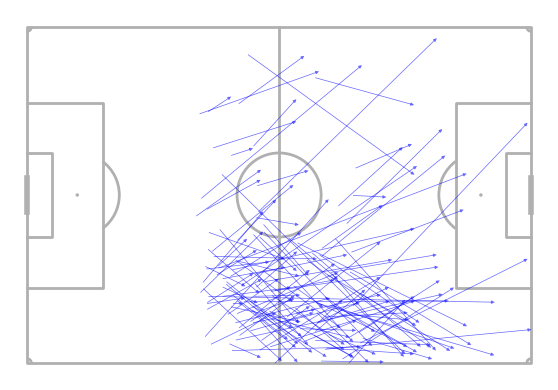

In [18]:
# get locations
start_location = np.vstack([df_plot["x"], df_plot["y"]]).T
end_location = np.vstack([df_plot["x_end_pass"], df_plot["y_end_pass"]]).T

# Calculate the change in x and y (vector direction)
dx = end_location[:, 0] - start_location[:, 0]  # difference in x (end_x - start_x)
dy = end_location[:, 1] - start_location[:, 1]  # difference in y (end_y - start_y)

# Draw pitch
pitch = Pitch(label=False, tick=False, linewidth=2, corner_arcs=True)
fig, ax = pitch.draw(figsize=(8, 4))

# Plot arrows using ax.quiver (from start_location to end_location)
# pitch.arrows(start_location[:, 0], start_location[:, 1], end_location[:, 0], end_location[:, 1]
#              ,ax=ax, width=0.8, zorder=2,color='lightblue', headwidth=10, headlength=10, headaxislength=10)

pitch.arrows(start_location[:, 0], start_location[:, 1], end_location[:, 0], end_location[:, 1]
             ,ax=ax, width=0.5, zorder=2,color='blue', headwidth=5, headlength=5, headaxislength=6, alpha=0.6)

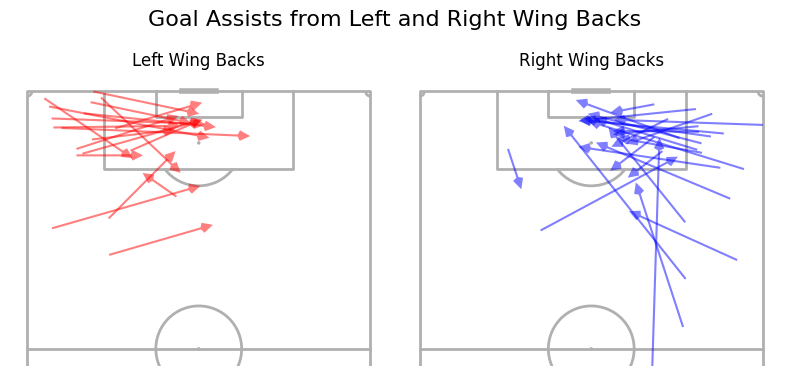

In [23]:
# Draw pitch
pitch = VerticalPitch(label=False, tick=False, linewidth=2, corner_arcs=True, half=True)
fig, ax = pitch.draw(nrows=1, ncols=2, figsize=(8, 4))
fig.suptitle("Goal Assists from Left and Right Wing Backs", fontsize=16)
# === left wing back ===
df_plot = df_with_flags[
    (df_with_flags["is_pass_goal_assist"] == True) &
    (~df_with_flags['is_right_corner']) &
    (~df_with_flags['is_left_corner']) &
    (df_with_flags["position_level_2"] == "Left Wing Back")
    ]
# get locations
start_location = np.vstack([df_plot["x"], df_plot["y"]]).T
end_location = np.vstack([df_plot["x_end_pass"], df_plot["y_end_pass"]]).T
ax[0].set_title(f"Left Wing Backs", fontsize=12)
pitch.arrows(start_location[:, 0], start_location[:, 1], end_location[:, 0], end_location[:, 1]
             ,ax=ax[0], width=1.5, zorder=2,color='red', headwidth=5, headlength=5, headaxislength=6, alpha=0.5)


# === right wing back ===
df_plot = df_with_flags[
    (df_with_flags["is_pass_goal_assist"] == True) &
    (~df_with_flags['is_right_corner']) &
    (~df_with_flags['is_left_corner']) &

    ((df_with_flags["position_level_2"] == "Right Wing Back"))

    ]
# get locations
start_location = np.vstack([df_plot["x"], df_plot["y"]]).T
end_location = np.vstack([df_plot["x_end_pass"], df_plot["y_end_pass"]]).T

# Calculate the change in x and y (vector direction)
ax[1].set_title(f"Right Wing Backs", fontsize=12)
pitch.arrows(start_location[:, 0], start_location[:, 1], end_location[:, 0], end_location[:, 1]
             ,ax=ax[1], width=1.5, zorder=2,color='blue', headwidth=5, headlength=5, headaxislength=6, alpha=0.5)

fig.savefig(f"{PROJECT_ROOT_DIR}/experiment_results/tuning/pitch_analysis.svg", format="svg")



# Pass Accuracy Differences

In [20]:
df_standard_stats = pd.read_csv("../../../data/new_approach/standard_stats_all_final.csv")
df_standard_stats = df_standard_stats.set_index("player_id")

df_passing = pd.read_csv("../../../data/new_approach/passing_ex.csv")
df_passing = df_passing.set_index("player_id")

df_merged = pd.merge(
    left=df_standard_stats,
    right=df_passing,
    left_index=True,
    right_index=True,
    how="left"
)   
df_merged =  df_merged.loc[(df_merged["match_played"]>=2) & (df_merged["minutes_played"]>=90), : ].copy()


print("Accuracy From Different Pitch Zones")
# print(df_merged["pass_accuracy_from_defending_third_%"].mean(), df_merged["pass_accuracy_from_middle_third_%"].mean(), df_merged["pass_accuracy_from_attacking_third_%"].mean())
# print(df_merged["up_pass_accuracy_from_defending_third_%"].mean(), df_merged["up_pass_accuracy_from_middle_third_%"].mean(), df_merged["up_pass_accuracy_from_attacking_third_%"].mean())

print("Accuracy From Into Pitch Zones")
print(df_merged["pass_accuracy_into_box_%"].mean(), df_merged["pass_accuracy_into_attacking_third_%"].mean(), df_merged["pass_accuracy_into_middle_third_%"].mean(), df_merged["pass_accuracy_into_defending_third_%"].mean())
# print(df_merged["up_pass_accuracy_into_defending_third_%"].mean(), df_merged["up_pass_accuracy_into_middle_third_%"].mean(), df_merged["up_pass_accuracy_into_attacking_third_%"].mean())

Accuracy From Different Pitch Zones
Accuracy From Into Pitch Zones
0.2772234799868864 0.5656993593197857 0.7896775711346711 0.8848205107402581


C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_10480\2715276067.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("RdYlGn")


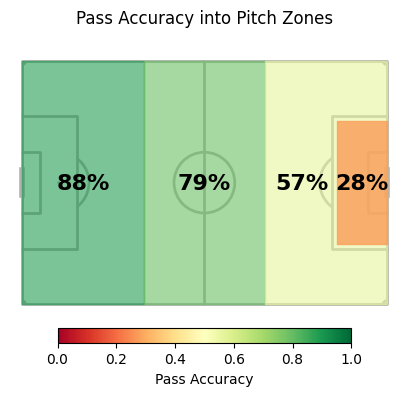

In [25]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Example pass accuracy values (replace with your calculations)
acc_def = 0.8848205107402581
acc_mid = 0.7896775711346711
acc_att = 0.5656993593197857
acc_box = 0.2772234799868864  # new accuracy for penalty box region

accuracies = [acc_def, acc_mid, acc_att]

# Diverging colormap
cmap = cm.get_cmap("RdYlGn")
norm = mcolors.Normalize(vmin=0, vmax=1)

# Draw pitch
pitch = Pitch(label=False, tick=False, linewidth=2, corner_arcs=True)
fig, ax = pitch.draw(figsize=(8, 4))
fig.suptitle("Pass Accuracy into Pitch Zones", fontsize=12)

pitch_length = pitch.dim.pitch_length
pitch_width = pitch.dim.pitch_width
third = pitch_length / 3

# ---- Shade thirds ----
for i, acc in enumerate(accuracies):
    left = i * third
    right = (i + 1) * third
    color = cmap(norm(acc))
    ax.fill_betweenx([0, pitch_width], left, right, color=color, alpha=0.6)

# ---- Add penalty box as extra region ----
box_left = pitch_length - 16.5   # standard penalty box distance from goal line
box_right = pitch_length
box_bottom = (pitch_width - 40.3) / 2  # penalty box height = 40.3m
box_top = box_bottom + 40.3

# Shade penalty box
ax.fill_betweenx([box_bottom, box_top], box_left, box_right,
                 color=cmap(norm(acc_box)), alpha=0.8)

# ---- Place text ----
y_center = pitch_width / 2
positions = [third/2, third*1.5, third*2.3]

for pos, acc in zip(positions, accuracies):
    ax.text(pos, y_center, f"{acc:.0%}",
            ha='center', va='center', fontsize=16, color="black", weight="bold")

# Penalty box text (centered inside box)
ax.text((box_left + box_right)/2, (box_bottom + box_top)/2, f"{acc_box:.0%}",
        ha='center', va='center', fontsize=16, color="black", weight="bold")

# ---- Colorbar ----
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.04, orientation="horizontal")
cbar.set_label("Pass Accuracy")

plt.show()
fig.savefig(f"{PROJECT_ROOT_DIR}/experiment_results/figures/pitch_zones.svg", format="svg")

